In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [14]:
NUM_RUNS = 10
# EPSILON = 0.3      # placeholder value - you should implement your own exploration schedule

In [15]:
# Since our task is not to find the best parameters, but to find good parameters with justification
# the parameter tuning is done by hand, and no grid search is performed.
runs_results = []
largest_omega = 0
env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4, 32, 16, 2])
    target_net = DQN([4, 32, 16, 2])
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=.02)
    memory = ReplayBuffer(10000)

    episode_durations = []
    batch_size = 50
    max_episodes = 350
    epsilon = 1
    epsilon_decay = 0.993
    # discount factor
    gamma = 0.8
    for i_episode in range(max_episodes):
        # Decay epsilon in each episode.
        epsilon *= epsilon_decay
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", max_episodes)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(epsilon, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            if largest_omega < abs(observation[3]):
                largest_omega = abs(observation[3])
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < 1:
                if len(memory.buffer) < batch_size:
                    transitions = memory.sample(len(memory.buffer))
                else:
                    transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss with the discount factor gamma.
                mse_loss = loss(gamma, policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 35 == 0: 
            update_target(target_net, policy_net)
    update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10


d:\miniconda\envs\rl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 350
episode  100 / 350
episode  150 / 350
episode  200 / 350
episode  250 / 350
episode  300 / 350
episode  350 / 350
Starting run 2 of 10
episode  50 / 350
episode  100 / 350
episode  150 / 350
episode  200 / 350
episode  250 / 350
episode  300 / 350
episode  350 / 350
Starting run 3 of 10
episode  50 / 350
episode  100 / 350
episode  150 / 350
episode  200 / 350
episode  250 / 350
episode  300 / 350
episode  350 / 350
Starting run 4 of 10
episode  50 / 350
episode  100 / 350
episode  150 / 350
episode  200 / 350
episode  250 / 350
episode  300 / 350
episode  350 / 350
Starting run 5 of 10
episode  50 / 350
episode  100 / 350
episode  150 / 350
episode  200 / 350
episode  250 / 350
episode  300 / 350
episode  350 / 350
Starting run 6 of 10
episode  50 / 350
episode  100 / 350
episode  150 / 350
episode  200 / 350
episode  250 / 350
episode  300 / 350
episode  350 / 350
Starting run 7 of 10
episode  50 / 350
episode  100 / 350
episode  150 / 350
episode  200 / 350
episode

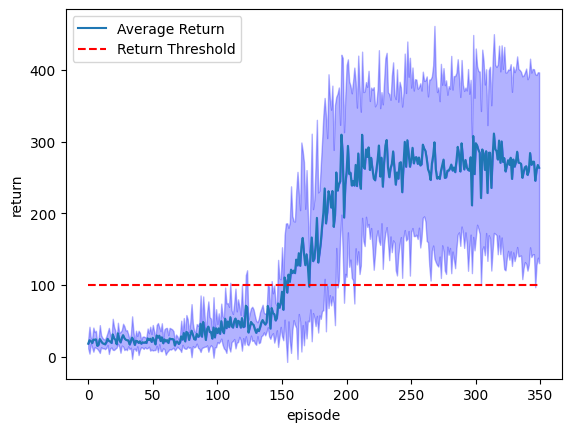

In [23]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)
max_episodes = len(means)

plt.plot(torch.arange(max_episodes), means, label='Average Return')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(max_episodes), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(max_episodes), means, means-stds, alpha=0.3, color='b')
plt.plot(np.arange(max_episodes), np.ones(max_episodes)*100, 'r--', label="Return Threshold")
plt.legend(loc='upper left')
plt.show()

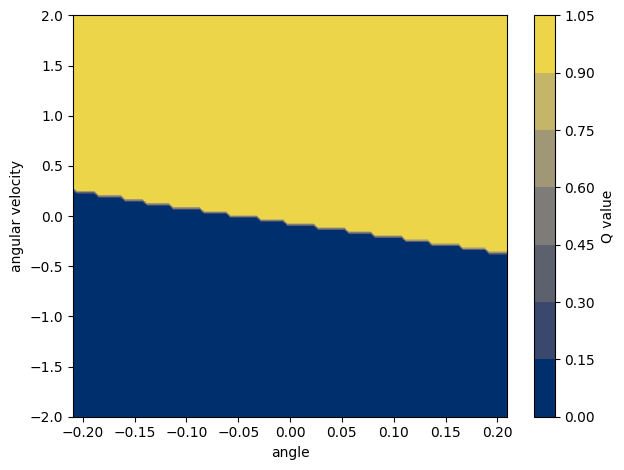

In [34]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

# Please run this cell after training the network, the network weights are stored in policy_net.
q = False    # whether q values or greedy policy is visualised

angle_range = 0.2095 # you may modify this range
omega_range = 2      # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0, angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.colorbar(label="Q value")
plt.tight_layout()
plt.show()